In [86]:
import csv
import pandas as pd
from geopy.distance import distance
from data.mapping import POSTCODE_MUNICIPALITY_LOOKUP
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv (r"data/Stadfangaskra.csv", header=[0])
df.drop(columns=['FID', 'HNITNUM', 'BYGGD', 'LANDNR',  'MATSNR', 'BOKST', 'VIDSK', 'SERHEITI', 'DAGS_INN', 'DAGS_LEIDR', 'GAGNA_EIGN', 'TEGHNIT', 'YFIRFARID', 'YFIRF_HEITI', 'ATH', 'NOTNR', 'LM_HEIMILISFANG', 'VEF_BIRTING'], inplace=True)
header = list(df.columns.values)

df["municipality"] = df.POSTNR.apply(lambda p: POSTCODE_MUNICIPALITY_LOOKUP.get(p, np.nan))
    
# post_nr_rvk =[float(x) for x in [101,102,103,104,105,107,108,109,110,111,112,113,116,121,123,124,125,127,128,129,130,132,150,155,161,162]]

df = df[df['municipality']=='Reykjavík']
df = df[df['HUSNR'].notna()]
# print(len(df))
df[0:10]
df['houses'] =[f"{row['HEITI_NF']} {int(row['HUSNR'])}, {int(row['POSTNR'])}" for _,row in df.iterrows()]

print(len(df))
df.drop_duplicates(subset='houses', inplace=True)
print(len(df))
df.sort_values(by='houses').to_csv('data/rvk.csv')

22069
20359


In [3]:
bs = pd.read_csv (r"data/bensinstodvar.csv", header=[0])
bs[0:5]

,Unnamed: 0,name,address,municipality,postcode,street_nominative,street_dative,house_nr,geometry
0,0,Atlantsolía,"Bíldshöfði 20, 110",Reykjavík,110,Bíldshöfði,Bíldshöfða,20.0,POINT (-21.81464694 64.1251776)
1,1,Atlantsolía,"Bústaðavegur 151, 108",Reykjavík,108,Bústaðavegur,Bústaðavegi,151.0,POINT (-21.84783045 64.12088042)
2,2,Atlantsolía,"Flugvallarvegur 5, 102",Reykjavík,102,Flugvallarvegur,Flugvallarvegi,5.0,POINT (-21.92489768 64.13159896)
3,3,Atlantsolía,"Háaleitisbraut 12, 108",Reykjavík,108,Háaleitisbraut,Háaleitisbraut,12.0,POINT (-21.89090998 64.1374088)
4,4,Atlantsolía,"Kirkjustétt 2-6, 113",Reykjavík,113,Kirkjustétt,Kirkjustétt,2.0,POINT (-21.75664476 64.12625023)


In [4]:
# def parallel_processor(function, iterator, chunks=90, units ='lines'):
#     results: set = set()
#     with ProcessPoolExecutor(max_workers=5) as executor:
#         results =  tqdm([executor.map(
#             function,
#             iterator,
#             chunksize=chunks)], 
#             total=len(iterator),
#             unit= ' '+ units)
#     return results

In [5]:
gas_stations=set([r['address'].split(',')[0] for i,r in bs.iterrows()])
print(gas_stations)
results = {}
for index,row in tqdm(df.iterrows(), total=len(df)):
    house = row['houses']
    if house not in gas_stations:        
        results[house] = {x:'NAN' for x in bs['address'].to_list()}
        coords_1 = (row['E_HNIT_WGS84'], row['N_HNIT_WGS84'])
        for i,r in bs.iterrows():
            coords_2 = r['geometry'].replace('POINT (','').replace(')','').replace(' ',',')
            results[house][r['address']] = distance(coords_1, coords_2).km

# print( d)
# df_test
pd.DataFrame(results).to_csv("data/distance2gas_km.csv")

{'Klettagarðar 6', 'Gagnvegur 2', 'Borgartún 39', 'Gylfaflöt 1', 'Hraunbær 102', 'Birkimelur 10', 'Barðastaðir 3', 'Vatnagarðar 40', 'Straumur 9', 'Bíldshöfði 5', 'Kirkjustétt 2-6', 'Ægisíða 102', 'Álfheimar 49', 'Laugavegur 180', 'Hringbraut 12', 'Skógarhlíð 16', 'Fjallkonuvegur 1', 'Grjótháls 8', 'Bíldshöfði 20', 'Sundagarðar 2', 'Kleppsvegur 96', 'Stóragerði  40', 'Bíldshöfði 2', 'Skúlagata 15', 'Fellsmúli 30', 'Elliðabraut - Norðlingaholt', 'Skeifan 5', 'Egilsgata 5', 'Skúlagata 9', 'Stekkjarbakki 2', 'Háaleitisbraut 12', 'Starengi 2', 'Spöngin 43', 'Vallargrund 3', 'Flugvallarvegur 5', 'Bústaðavegur 151', 'Kringlumýrarbraut 100', 'Norðlingabraut 7', 'Ánanaust 12', 'Miklabraut 101', 'Suðurfell 4', 'Álfabakki 7'}


100%|██████████| 20359/20359 [05:49<00:00, 58.31it/s]


In [46]:
dist2gas_km=pd.read_csv('data/distance2gas_km.csv', index_col=[0], header=[0]).T

In [57]:
import math
def roundup(x):
    return int(math.ceil(x / 5.0)) * 5

walking_speed=6
dist2gas_min=dist2gas_km.divide(walking_speed)*60

res = dist2gas_min.copy()
res[:] = np.nan

counts={}
for name in dist2gas_min.columns:
    for row in dist2gas_min.index:
        value=dist2gas_min.loc[row,name]
        rounded_value =roundup(value)
        res.loc[row,name] = rounded_value
        if rounded_value in counts:
            counts[rounded_value]+=1
        else:
            counts[rounded_value]=1

res.to_csv(f'data/bensinstodvar_min.csv')


In [88]:
the_sum =sum(counts.values())

with open('data/stats','w') as f_in:
    f_in.write(f"Sum:\t{the_sum}\n")
    f_in.write("min\tcount\tratio%\tcumulative%\n")
    cumulative=0
    x_axis=[]
    y_axis=[]
    for x in sorted(counts):
        ratio=(counts[x]/the_sum)*100
        cumulative+=ratio
        x_axis.append(x)
        y_axis.append(cumulative)
        f_in.write(f"{x}\t{counts[x]}\t{round(ratio,3)}\t{round(cumulative ,3)}\n")

In [92]:
ibuar_per_postnr={int(x.split('\t')[0]):int(x.split('\t')[1]) for x in open('data/ibuafjoldi_per_postnr.tsv')}
heildarfjoldi_ibua = sum(ibuar_per_postnr.values())
ibur_per_postnr_porportion

TypeError: unsupported operand type(s) for +: 'int' and 'str'

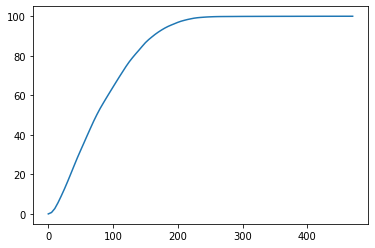

In [89]:
plt.plot(x_axis,y_axis)
plt.xlabel('Mínútur ')
plt.ylabel('entry b')